In [3]:
import torch
import torch.nn as nn
import helper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


In [5]:
train_loader, test_loader = helper.load_dataset(batch_size=64)

Loading the CIFAR10 dataset
Loaded train data: 50000 total samples, 782 batches
Loaded test data: 10000 total samples, 157 batches


In [6]:
import torch
import torch.nn as nn

class SmallCIFARConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), # conv1
            nn.ReLU(inplace=False),

            nn.Conv2d(32, 64, 3, stride=2, padding=1), # conv2
            nn.ReLU(inplace=False),

            nn.Conv2d(64, 128, 3, stride=2, padding=1), # conv3
            nn.ReLU(inplace=False),

            nn.Conv2d(128, 256, 3, stride=2, padding=1), # conv4
            nn.ReLU(inplace=False),
        )
        self.classifier = nn.Conv2d(256, num_classes, kernel_size=1) # conv5
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        # self.classifier = nn.Linear(256, num_classes)

    def forward(self, x,e=None):
        x = self.features(x)
        # x = x.mean(dim=(2, 3))  # GAP
        self.classifier(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        # x = self.classifier(x)
        return x

In [7]:
model = SmallCIFARConvNet()
model.load_state_dict(torch.load("small_cifar_fp32_1.pth"))

<All keys matched successfully>

In [8]:
metrics = helper.train_model(model,train_loader,test_loader,device=device)

Epoch [1/10] Train Loss: 2.1876, Train Acc: 48.29% Test/Val Loss: 1.5473, Test/Val Acc: 47.63%
Epoch [2/10] Train Loss: 2.1776, Train Acc: 48.45% Test/Val Loss: 1.5470, Test/Val Acc: 47.51%
Epoch [3/10] Train Loss: 2.1744, Train Acc: 48.86% Test/Val Loss: 1.5791, Test/Val Acc: 47.87%
Epoch [4/10] Train Loss: 2.1673, Train Acc: 49.23% Test/Val Loss: 1.6042, Test/Val Acc: 47.52%
Epoch [5/10] Train Loss: 2.1638, Train Acc: 49.44% Test/Val Loss: 1.4907, Test/Val Acc: 49.28%
Epoch [6/10] Train Loss: 2.1597, Train Acc: 49.50% Test/Val Loss: 1.5275, Test/Val Acc: 48.88%
Epoch [7/10] Train Loss: 2.1540, Train Acc: 49.54% Test/Val Loss: 1.5272, Test/Val Acc: 49.15%
Epoch [8/10] Train Loss: 2.1479, Train Acc: 50.17% Test/Val Loss: 1.5375, Test/Val Acc: 47.96%
Epoch [9/10] Train Loss: 2.1510, Train Acc: 49.83% Test/Val Loss: 1.5291, Test/Val Acc: 50.31%
Epoch [10/10] Train Loss: 2.1439, Train Acc: 50.32% Test/Val Loss: 1.5426, Test/Val Acc: 50.46%


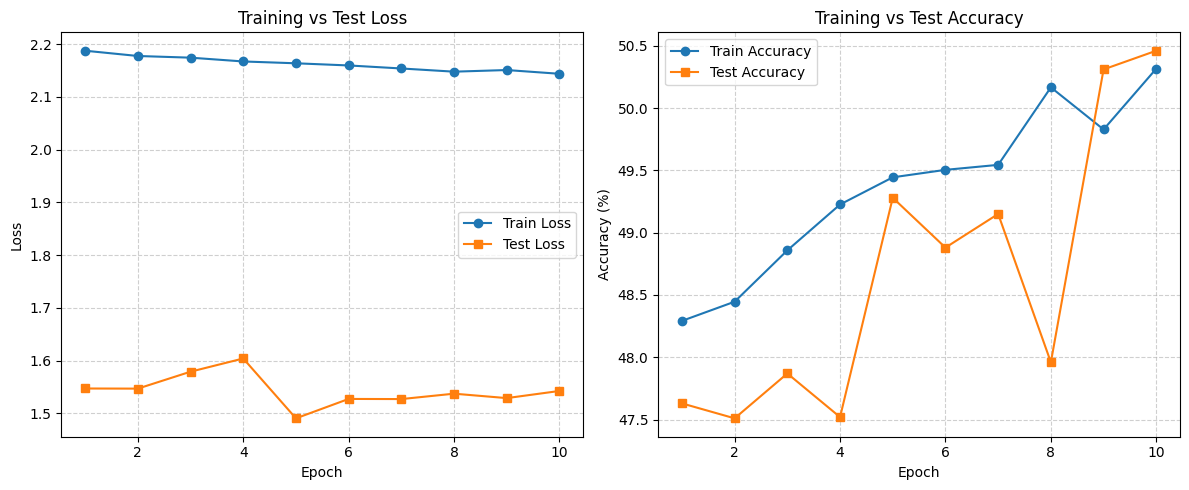

In [9]:
helper.plot_metrics(metrics)

In [10]:
torch.save(model.state_dict(), "small_cifar_fp32_final.pth")

## QAT

In [11]:
model = SmallCIFARConvNet()
model.load_state_dict(torch.load("small_cifar_fp32_final.pth", map_location="cpu"))
model.eval()

SmallCIFARConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (classifier): Conv2d(256, 10, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [ ]:
import torch.quantization as tq

class QuantWrapper(nn.Module):
    def __init__(self, fp32_model: nn.Module):
        super().__init__()

        self.quant = tq.QuantStub()
        self.model = fp32_model
        self.dequant = tq.DeQuantStub()

    def forward(self, x, e=None):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x


In [13]:
def fuse_sequential(model):
    tq.fuse_modules(
        model.features,
        [
            ['0', '1'],
            ['2', '3'],
            ['4', '5'],
            ['6', '7'],
            ['8', '9'],
        ],
        inplace=True
    )


In [15]:
import torch

# 1. Create FP32 model
fp32_model = SmallCIFARConvNet()
fp32_model.load_state_dict(torch.load("small_cifar_fp32_final.pth", map_location="cpu"))

# 2. Wrap it
qat_model = QuantWrapper(fp32_model)
qat_model.train()

# 3. Backend
torch.backends.quantized.engine = "fbgemm"

# 4. QAT config
qat_model.qconfig = tq.get_default_qat_qconfig("fbgemm")

# 5. Fuse
# fuse_sequential(qat_model.model)
for i in range(0, len(qat_model.model.features), 2):
    if isinstance(qat_model.model.features[i], nn.Conv2d) and isinstance(qat_model.model.features[i+1], nn.ReLU):
        tq.fuse_modules(qat_model.model.features, [str(i), str(i+1)], inplace=True)


# 6. Prepare QAT
tq.prepare_qat(qat_model, inplace=True)


C:\Users\K\AppData\Local\Temp\ipykernel_7748\1943725077.py:25: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  tq.prepare_qat(qat_model, inplace=True)
c:\Users\K\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\ao\quantization\observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range

QuantWrapper(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (model): SmallCIFARConvNet(
    (features): Sequential(
      (0): ConvReLU2d(
        3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
          (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
        )
  

In [17]:
metrics = helper.train_model(qat_model,train_loader,test_loader)

Epoch [1/10] 

TypeError: QuantWrapper.forward() takes 2 positional arguments but 3 were given

In [ ]:
torch.save(model.state_dict(), "small_cifar_qat.pth")

In [ ]:
qat_model.eval()
int8_model = tq.convert(qat_model)
torch.save(model.state_dict(), "small_cifar_q.pth")